<a href="https://colab.research.google.com/github/nesanders/mywra_precipitation_2022/blob/main/2022_05_24_MyRWA_29yr_Precipitation_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Purpose

This notebook contains an analysis of 29 years of Mystic River watershed (MA) precipitation data compiled by the MystiC River Watershed Association.

# Imports

In [1]:
import io
import logging
from typing import Any, Optional

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from googleapiclient.http import MediaIoBaseDownload


# Definitions

Relevant data files are stored in the [MyRWA Policy Committee Google Shared Drive here](https://drive.google.com/drive/u/0/folders/1Muur6sIeTPDvzS7OjNY2jPJq2cBbVfql).

In [42]:
PRECIP_DATA_FILE_URL = 'https://docs.google.com/spreadsheets/d/14gZAM1uW3XvvkcJuwnJFTYhITuYL87iu/edit?usp=drive_web&ouid=101677718735234570704&rtpof=true'
CSO_DATA_FILE_URL = 'https://docs.google.com/spreadsheets/d/18y3Tl1ehAW4tflJ7tqw0pI0V7M5u6ILj/edit?usp=drive_web&ouid=101677718735234570704&rtpof=true'

MWRA_CSO_DATA_FILE_URL = 'https://docs.google.com/spreadsheets/d/1rHgjIaMvhCSDDRaYLBkthAI64x1NEprE/edit?usp=drive_web&ouid=101677718735234570704&rtpof=true'

In [3]:
def read_excel_from_google_drive(url: str, **kwargs) -> pd.DataFrame:
    """If given a Google drive share link for an Excel file, construct a file 
    URL and pass it to pd.read_excel
    """
    file_url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
    return pd.read_excel(file_url, **kwargs)

In [4]:
def extract_storm_events(
  rain_data: pd.Series, 
  threshold: float=1e-3, 
  window: int=4
) -> pd.DataFrame:
    """Use a simple windowing algorithm to identify storm events.
    
    This works by scanning across the timeseries data using a rolling average.  
    If the rolling average over a window `window` drops below `threshold, the 
    storm event is considered to have ended.

    Parameters
    ----------
    rain_data: pd.Series
        Input DataFrame of precipitation timeseries
    threshold: float=0
        Severity threshold; average rainfall above this value is considered a 
        storm
    window: int=4
        A contiguous storm event is defined by having a rolling average over 
        this window size yielding an average precipitation > `threshold`.
    
    Returns
    -------
    pd.DataFrame
        Has the following columns:
        index : sequential integer ID of the storm
        'total_precip' : integrated rainfall value of that storm
        'start_time', 'end_time' : stat and end timestamps of the storm
    """
    event_mask = (
        rain_data.rolling(window=window).mean() > threshold).astype(int)
    event_mask_edges = event_mask[1:] - event_mask[:-1].values
    event_counter = (event_mask_edges == 1).cumsum()
    n_events = max(event_counter)
    out_dict = {
        'start_time': event_mask_edges.index[event_mask_edges == 1],
        'end_time': event_mask_edges.index[event_mask_edges == -1],
        'total_precip': [rain_data.where(event_counter == n).sum() 
                        for n in range(n_events)]
    }
    # The first element will be a non-storm, so we trim it from the output
    return pd.DataFrame(out_dict).iloc[1:]
  

# Get data
Follows the example here https://stackoverflow.com/a/56611995

Note - all files must have permissions set to world-readable for this to work.

In [48]:
# NOTE: This file is large and can take a minute or so to run
precip_data_df = read_excel_from_google_drive(PRECIP_DATA_FILE_URL) 

In [47]:
cso_data_df = read_excel_from_google_drive(CSO_DATA_FILE_URL)

In [62]:
# This data frile from MWRA contains CSO activations in the Mystic and Charles. 
# We subset it to the Mystic events after loading.
mwra_cso_data_df = read_excel_from_google_drive(
    MWRA_CSO_DATA_FILE_URL, 
    sheet_name='2015-2020_CSO_activations', 
    skiprows=1)

# See Table 1 of this document for watershed identifications 
# https://www.mass.gov/doc/massachusetts-water-resources-authority-combined-sewer-overflow-control-plan-cso-post/download
# These CSOs have data present, but are not in the Mystic
# > 'BOS003', 'BOS004', 'BOS009', 'BOS010', 'BOS012', 'BOS019', 'BOS046', 
# > 'BOS057', 'BOS060', 'BOS062', 'BOS064', 'BOS065', 'BOS068', 'BOS070/DBC', 
# > 'BOS070/RCC', 'BOS073', 'BOS076', 'BOS078', 'BOS079', 'BOS080', 'CAM005', 
# > 'CAM007', 'CAM017', 'MWR018', 'MWR019', 'MWR020', 'MWR023', 'MWR201', 
# > 'MWR203',  'MWR215'
ALEWIFE_OUTFALL_IDS = ['CAM001', 'CAM002', 'CAM004', 'MWR003', 'CAM400', 
                       'CAM401A','CAM401B', 'SOM001', 'SOM001A', 'SOM002A', 
                       'SOM003', 'SOM004']
UPPER_MYSTIC_OUTFALL_IDS = ['SOM007A/MWR205A', 'SOM007']
MYSTIC_CHELSEA_OUTFALL_IDS = ['MWR205', 'BOS013', 'BOS014', 'BOS015', 'BOS017',
                              'CHE002', 'CHE003', 'CHE004', 'CHE008']
MYSTIC_OUTFALL_IDS = ALEWIFE_OUTFALL_IDS + UPPER_MYSTIC_OUTFALL_IDS + \
    MYSTIC_CHELSEA_OUTFALL_IDS
mwra_cso_data_df_mystic = mwra_cso_data_df[mwra_cso_data_df['CSO_ID']\
    .isin(MYSTIC_OUTFALL_IDS)]

# Exploratory Analysis

In [7]:
# Minor formatting tweaks
precip_data_df.rename(columns={'Date/Time': 'time'}, inplace=True)
precip_data_df.set_index('time', inplace=True)

In [8]:
LOCATIONS = precip_data_df.columns.tolist()
print(LOCATIONS)

['BO-DI-2 (in)', 'CH-BO-1 (in)']


In [9]:
# Ensure sorting
precip_data_df.sort_index(inplace=True)

# Ensure consistent sampling
template_spacing = (precip_data_df.index[1] - precip_data_df.index[0]).seconds
np.testing.assert_allclose(
    (precip_data_df.index[1:] - precip_data_df.index[:-1]).seconds, 
    np.ones(len(precip_data_df) - 1) * template_spacing,
    err_msg="Spacing of precip_data_df timestamps is not uniform",
    atol=1)

In [10]:
# Run storm finding algorithm
# NOTE this is slow - it takes >15 minutes!
storm_dfs = {}
for col in LOCATIONS:
    print(f'Extracting storms from {col}')
    storm_dfs[col] = extract_storm_events(precip_data_df.loc[:, col])

Extracting storms from BO-DI-2 (in)
Extracting storms from CH-BO-1 (in)


### Precipitation

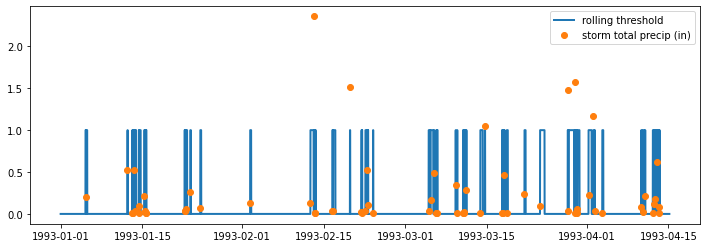

In [11]:
# Plot a few months of rolling thresholded data
x = (precip_data_df.rolling(4).mean() > 1e-3).astype(float)[:10000]
plt.figure(figsize=(12, 4))
plt.plot(x.index, x.values[:, 0], lw=2, marker=None, label='rolling threshold')
col_a = list(storm_dfs.keys())[0]
sel = storm_dfs[col_a]['start_time'] < x.index.max()
plt.plot(storm_dfs[col_a].loc[sel, 'start_time'], 
         storm_dfs[col_a].loc[sel, 'total_precip'], 
         marker='o', label='storm total precip (in)', lw=0)
plt.legend()

Text(0, 0.5, 'Storm edges')

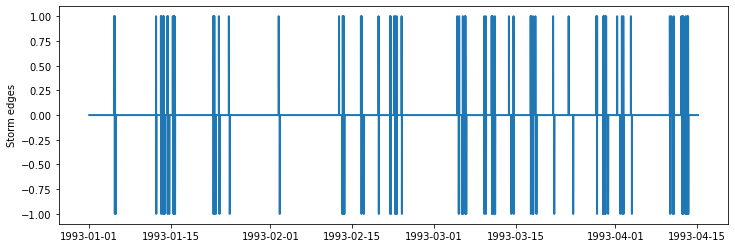

In [12]:
# Plot a few months of rolling threshold edge data
x = (precip_data_df.rolling(4).mean() > 1e-3).astype(float)[:10000]
plt.figure(figsize=(12, 4))
plt.plot(x.index[:-1], x.values[1:, 0] - x.values[:-1, 0], lw=2, marker=None)
plt.ylabel('Storm edges')

In [13]:
storm_dfs

{'BO-DI-2 (in)':                   start_time                end_time  total_precip
 1    1993-01-05 09:45:00.000 1993-01-05 13:15:00.000          0.20
 2    1993-01-12 10:30:00.000 1993-01-12 11:30:00.000          0.52
 3    1993-01-13 06:30:00.000 1993-01-13 07:30:00.000          0.01
 4    1993-01-13 08:00:00.000 1993-01-13 15:00:00.000          0.01
 5    1993-01-13 15:15:00.000 1993-01-13 18:00:00.000          0.53
 ...                      ...                     ...           ...
 6728 2021-12-25 08:29:59.787 2021-12-25 15:59:59.787          0.07
 6729 2021-12-26 00:44:59.787 2021-12-26 05:44:59.787          0.33
 6730 2021-12-28 05:14:59.787 2021-12-28 06:14:59.787          0.19
 6731 2021-12-30 11:44:59.787 2021-12-30 14:29:59.787          0.01
 6732 2021-12-30 15:14:59.787 2021-12-30 17:44:59.787          0.04
 
 [6732 rows x 3 columns],
 'CH-BO-1 (in)':                   start_time                end_time  total_precip
 1    1993-01-12 10:15:00.000 1993-01-12 11:15:00.000   

### CSOs

Text(0.5, 0, 'Discharge volume (M gallons)')

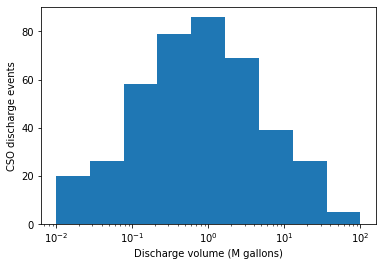

In [14]:
# Volume distribution
cso_data_df.loc[:, 'Volume (million gallons)'].plot(kind='hist', 
                                                    bins=np.logspace(-2, 2, 10))
plt.semilogx()
plt.ylabel('CSO discharge events')
plt.xlabel('Discharge volume (M gallons)')

Text(0.5, 0, 'Cumulative count of CSO events')

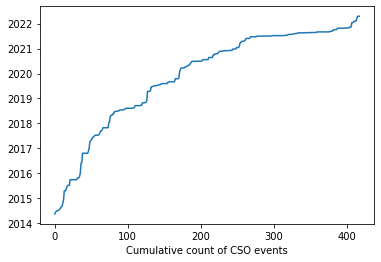

In [15]:
# Date distribution
cso_dates = cso_data_df.loc[:, 'Discharge Date']\
  .sort_values().reset_index(drop=True).plot()
plt.xlabel('Cumulative count of CSO events')

In [16]:
# Location distribution
cso_data_df.groupby(['CSO Number', 'Treated or Untreated']).apply(len)

CSO Number        Treated or Untreated
BOS019            Untreated                7
MWR003            Untreated                6
MWR018            Untreated                4
MWR019            Untreated                4
MWR020            Untreated                4
MWR023            Untreated                4
MWR201            Treated                  8
MWR203            Treated                 35
MWR205            Treated                 58
MWR215            Treated                 23
SOM007A/ MWR205A  Treated                 26
dtype: int64

## CSOs (MWRA)

In [53]:
mwra_cso_data_df

,CSO_ID,CSO_DISCHARGE_START,CSO_DISCHARGE_STOP,CSO_DURATION,TOTAL_VOLUME,DATA_SOURCE,TREATMENT_TYPE,COMMENTS
0,BOS003,2015-06-21 08:31:00,2015-06-21 09:38:00,1.12,0.140,MODEL,UNTREATED,NaN
1,BOS003,2015-06-28 08:45:00,2015-06-28 10:44:00,1.98,0.460,MODEL,UNTREATED,NaN
2,BOS003,2015-07-10 03:15:00,2015-07-10 03:57:00,0.71,0.070,MODEL,UNTREATED,NaN
3,BOS003,2015-09-30 08:15:00,2015-09-30 16:44:00,8.48,3.850,MODEL,UNTREATED,NaN
4,BOS003,2016-01-10 12:16:00,2016-01-10 14:57:00,2.68,0.490,MODEL,UNTREATED,NaN
...,...,...,...,...,...,...,...,...
1442,SOM007A/MWR205A,2020-06-29 12:05:00,2020-06-29 12:29:00,0.25,0.097,METER,TREATED,Rainfall is the daily precipitation total meas...
1443,SOM007A/MWR205A,2020-08-23 17:12:00,2020-08-23 18:05:00,0.25,0.430,METER,TREATED,Rainfall is the daily precipitation total meas...
1444,SOM007A/MWR205A,2020-11-30 22:45:00,2020-12-01 02:00:00,3.25,5.120,METER,TREATED,Rainfall is the daily precipitation total meas...
1445,SOM007A/MWR205A,2020-12-05 13:35:00,2020-12-05 16:45:00,3.16,3.030,METER,TREATED,Initial field report indicated start and stop ...


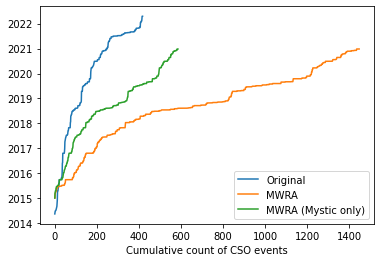

In [63]:
# Compare date distribution of this data table to the previous CSO data table
plt.figure()
cso_data_df.loc[:, 'Discharge Date'].sort_values()\
    .reset_index(drop=True).plot(label='Original')
mwra_cso_data_df.loc[:, 'CSO_DISCHARGE_START'].sort_values()\
    .reset_index(drop=True).plot(label='MWRA')
mwra_cso_data_df_mystic.loc[:, 'CSO_DISCHARGE_START'].sort_values()\
    .reset_index(drop=True).plot(label='MWRA (Mystic only)')
plt.xlabel('Cumulative count of CSO events')
plt.legend()

# Plots (Precipitation)

## 1. Storm events per year
Make a line plot of total storm events per year

In [17]:
storm_df_samp = pd.DataFrame({
    col: df.set_index('start_time').resample('Y')['total_precip'].agg(len) 
    for col, df in storm_dfs.items()
})

Text(0.5, 0, 'Year')

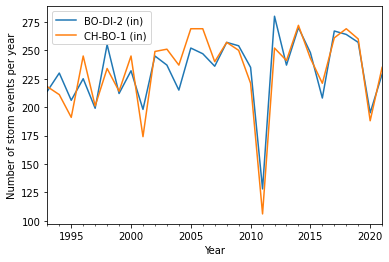

In [18]:
storm_df_samp.plot()
plt.ylabel('Number of storm events per year')
plt.xlabel('Year')

## 2. Average storm severity
Make a line plot of average storm severity (in inches) per year

In [19]:
storm_df_samp_precip = pd.DataFrame({
    col: df.set_index('start_time').resample('Y')['total_precip'].mean()
    for col, df in storm_dfs.items()
})

Text(0.5, 0, 'Year')

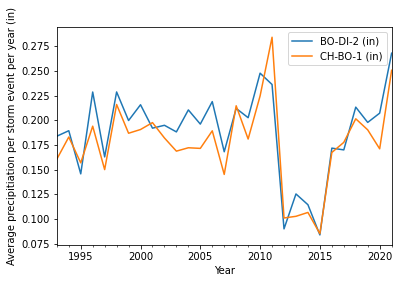

In [20]:
storm_df_samp_precip.plot()
plt.ylabel('Average precipitiation per storm event per year (in)')
plt.xlabel('Year')

## 3. Extreme storm severity

Make a line plot of 90th percentile storm severity (in inches) per year


In [21]:
QUANTILE = 0.9
storm_df_samp_quantile = pd.DataFrame({
    col: df.set_index('start_time').resample('Y')['total_precip']\
        .quantile(QUANTILE)
    for col, df in storm_dfs.items()
})

Text(0.5, 0, 'Year')

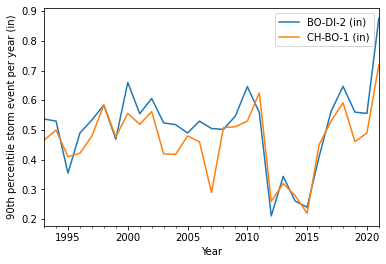

In [22]:
storm_df_samp_quantile.plot()
plt.ylabel(f'{int(QUANTILE*100)}th percentile storm event per year (in)')
plt.xlabel('Year')

## 4. Monthly storm frequency evolution

Make a lineplot of # storm events per month, which different lines for each 5 yr period

In [23]:
storm_df_samp_monthly = pd.DataFrame({
    col: df.set_index('start_time').resample('M')['total_precip'].apply(len)
    for col, df in storm_dfs.items()
})
storm_df_samp_monthly.reset_index(inplace=True)
storm_df_samp_monthly['month'] = storm_df_samp_monthly['start_time']\
    .apply(lambda x: x.month)

In [24]:
storm_df_samp_monthly.set_index('start_time', inplace=True)
print(storm_df_samp_monthly)
storm_df_samp_monthly_samp = storm_df_samp_monthly.resample('10Y')

            BO-DI-2 (in)  CH-BO-1 (in)  month
start_time                                   
1993-01-31            17            10      1
1993-02-28            14            16      2
1993-03-31            25            25      3
1993-04-30            23            24      4
1993-05-31            13            16      5
...                  ...           ...    ...
2021-08-31            19            18      8
2021-09-30            21            16      9
2021-10-31            23            25     10
2021-11-30            12            15     11
2021-12-31            20            21     12

[348 rows x 3 columns]


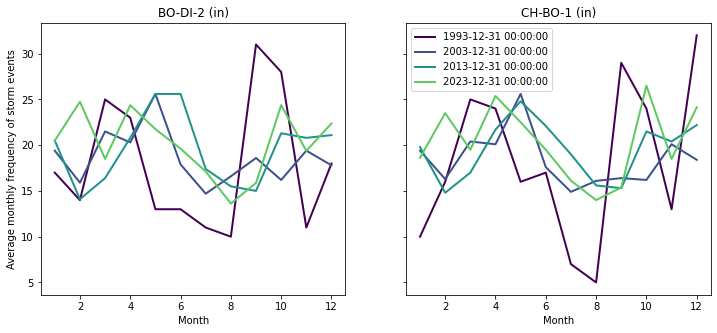

In [25]:
fig, axs = plt.subplots(1, len(LOCATIONS), figsize=(12,5), 
                        sharex='all', sharey='all')
for group_i, (group, group_df) in enumerate(storm_df_samp_monthly_samp):
    for ax_i, location in enumerate(LOCATIONS):
        gdf = group_df.groupby('month').mean()
        color = plt.cm.viridis(group_i / len(storm_df_samp_monthly_samp))
        axs[ax_i].plot(gdf.index, gdf[location], label=group, color=color, lw=2)

for i, ax in enumerate(axs):
    ax.set_title(LOCATIONS[i])
    ax.set_xlabel('Month')

axs[0].set_ylabel('Average monthly frequency of storm events')

plt.legend()

## 5. Monthly storm severity evolution


Make a lineplot of average storm severity (in inches) per month, which different lines for each 5 yr period


In [26]:
storm_df_samp_monthly_precip = pd.DataFrame({
    col: df.set_index('start_time').resample('M')['total_precip'].sum()
    for col, df in storm_dfs.items()
})
storm_df_samp_monthly_precip.reset_index(inplace=True)
storm_df_samp_monthly_precip['month'] = \
    storm_df_samp_monthly_precip['start_time'].apply(lambda x: x.month)

In [27]:
storm_df_samp_monthly_precip.set_index('start_time', inplace=True)
print(storm_df_samp_monthly)
storm_df_samp_monthly_precip_samp = storm_df_samp_monthly_precip.resample('10Y')

            BO-DI-2 (in)  CH-BO-1 (in)  month
start_time                                   
1993-01-31            17            10      1
1993-02-28            14            16      2
1993-03-31            25            25      3
1993-04-30            23            24      4
1993-05-31            13            16      5
...                  ...           ...    ...
2021-08-31            19            18      8
2021-09-30            21            16      9
2021-10-31            23            25     10
2021-11-30            12            15     11
2021-12-31            20            21     12

[348 rows x 3 columns]


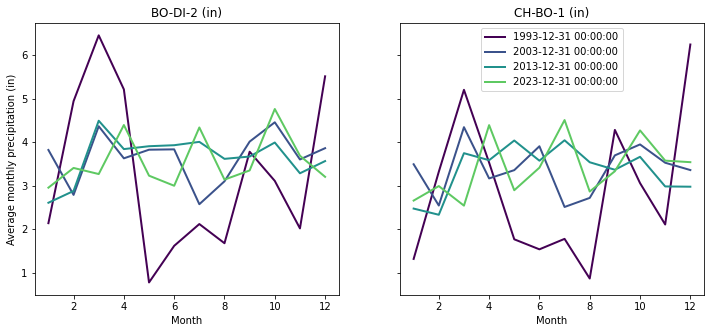

In [28]:
fig, axs = plt.subplots(1, len(LOCATIONS), figsize=(12,5), 
                        sharex='all', sharey='all')
for group_i, (group, group_df) in enumerate(storm_df_samp_monthly_precip_samp):
    for ax_i, location in enumerate(LOCATIONS):
        gdf = group_df.groupby('month').mean()
        color = plt.cm.viridis(group_i / len(storm_df_samp_monthly_precip_samp))
        axs[ax_i].plot(gdf.index, gdf[location], label=group, color=color, lw=2)

for i, ax in enumerate(axs):
    ax.set_title(LOCATIONS[i])
    ax.set_xlabel('Month')

axs[0].set_ylabel('Average monthly precipitation (in)')

plt.legend()

## 6. Distribution of severity

Make a cumulative distribution function of storm severity, with a different line for each 5 yr period

# Plots (CSOs)

**Warning: The current CSO dataset does not have exact start times, but rather start dates.  As a result, there will be an uncertainty of <= 24 hrs in the measured times. We therefore de-emphasize results at timescales <1 day below.**

In [29]:
REFERENCE_LOCATION = 'BO-DI-2 (in)'
def get_reference_storm_data() -> pd.DataFrame:
    """Return the DataFrame `storm_dfs[REFERENCE_LOCATION]`.
    """
    return storm_dfs[REFERENCE_LOCATION]

In [30]:
def check_dates(date: Any, storm_dates: Any):
    """Check types of `date` and `storm_dates`; both should be Timestamp-like.
    """
    assert isinstance(storm_dates, pd.Series), 'storm_dates must be a Series'
    assert storm_dates.dtype == 'datetime64[ns]', \
        'Storm dates must be datetime64'
    assert isinstance(date, pd.Timestamp), 'date must be a Timestamp'

## Calculate time offset from nearest previous storm event


In [31]:
def hrs_since_last_storm(
    date: pd.Timestamp, 
    storm_dates: Optional[pd.Series]=None
) -> float:
    """Calculate how many hours elapsed between the start of the previous storm 
    event in `storm_dates` and the input `date`.

    If `None`, `storm_dates` will be set to `get_reference_storm_dates()`
    """
    if storm_dates is None:
        storm_dates = get_reference_storm_data()['start_time']
    check_dates(date, storm_dates)
    if date > storm_dates.max():
        logging.warning(f'`date` {date} is outside of `storm_dates` range; '
                        f'will return np.nan')
        return np.nan
    diff = (date - storm_dates).dt.days*24
    return diff[diff > 0].min()


In [32]:
discharge_delta = cso_data_df['Discharge Date'].apply(hrs_since_last_storm)

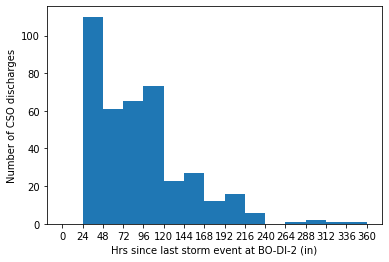

In [33]:
bins_24hr = np.arange(0,16)*24
discharge_delta.plot(kind='hist', bins=bins_24hr)
plt.xlabel(f'Hrs since last storm event at {REFERENCE_LOCATION}')
plt.ylabel('Number of CSO discharges')
plt.xticks(bins_24hr)
plt.show()

## Compare distribution of total precipitation with or without CSO

In [34]:
def sum_precip_prev_hr(
    date: pd.Timestamp, 
    prev_hr: float=48,
    storm_data: Optional[pd.DataFrame]=None
) -> float:
    """Calculate the sum of precipitation in the `prev_hr` hrs prior to `date`.

    If `None`, `storm_data` will be set to `get_reference_storm_dates()`
    """
    if storm_data is None:
        storm_data = get_reference_storm_data()
    check_dates(date, storm_data['start_time'])
    if date > storm_data['start_time'].max():
        logging.warning(f'`date` {date} is outside of `storm_dates` range; '
                        f'will return np.nan')
        return np.nan
    time_diff = (date - storm_data['start_time']).dt.days*24
    return storm_data.loc[(time_diff >= 0) & (time_diff <= prev_hr), 'total_precip'].sum()


In [35]:
def evaluate_prev_precip(prev_hr: float, location: Optional[str]=None):
    """Apply `sum_precip_prev_hr` to calculate the total precipitation in the 
    `prev_hr` period before each CSO events, and for a reference date series.

    Parameters
    ----------
    prev_hr : float
        Number of hours prior to the storm over which to integrate 
        precipitation by filtering on the 'CSO Number' column of `cso_data_sel`.
    location :  Optional[str]
        If not None, all data will be subset to this location. By default None.

    Returns
    -------
    pd.Series
        Total precip in the `prev_hr` period before each CSO event.
    pd.Series
        Total precip in all available contiguous periods of length `prev_hr` 
        between the first and last recorded CSO events.
    """
    if location is None:
        cso_data_sel = cso_data_df.copy()
    else:
        cso_data_sel = cso_data_df[cso_data_df['CSO Number'] == location]

    # Calculate precipitation prior to discharge events
    precip_prev = cso_data_sel['Discharge Date'].apply(sum_precip_prev_hr, 
                                                      prev_hr=prev_hr)
    # Calculate precipitation in arbitrary 48 hr periods
    all_dates = np.arange(cso_data_sel['Discharge Date'].min(), 
                          cso_data_sel['Discharge Date'].max(), 
                          np.timedelta64(48, 'h'),
                          dtype='datetime64[h]').astype('datetime64[ns]')
    precip_arbitrary = pd.Series(all_dates).apply(sum_precip_prev_hr,
                                                  prev_hr=prev_hr)
    return precip_prev, precip_arbitrary

In [36]:
def plot_evaluate_prev_precip(prev_hr: float, location: Optional[str]=None, 
                              ax: Optional['plt.Axes']=None
                              ) -> None:
    """Extract cumulative precipitation data using evaluate_prev_precip and then
    make a histogram plot.
    If `ax` is not None, the plot will be added to this axis.
    """
    precip_prev, precip_arbitrary = evaluate_prev_precip(prev_hr, location)
    max_precip = max(precip_prev.max(), precip_arbitrary.max())
    precip_bins = np.linspace(0, max_precip, 25)
    if ax is None:
        _, ax = plt.subplots(1)
    precip_prev.plot(kind='hist', bins=precip_bins, lw=3, 
                     label='Discharge dates', density=True, ax=ax)
    precip_arbitrary.plot(kind='hist', bins=precip_bins, lw=1, 
                          label='All dates', density=True, histtype='step', 
                          ax=ax)
    ax.legend()
    ax.set_xlabel(f'Total precipitation in {prev_hr} hrs since discharge (inches)')
    ax.set_ylabel('Frequency')
    if 'location' is not None:
        ax.set_title(location)

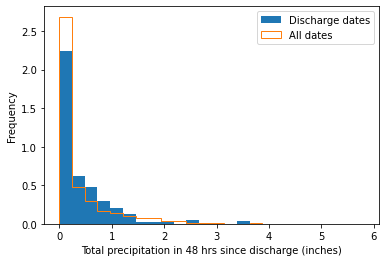

In [37]:
# 2 day period - all events
plot_evaluate_prev_precip(48)

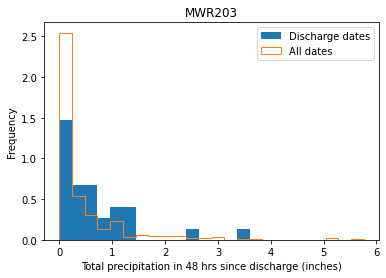

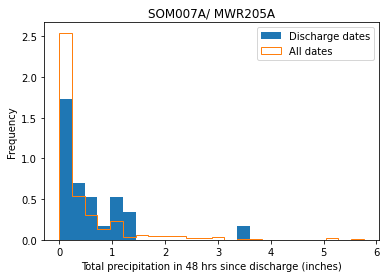

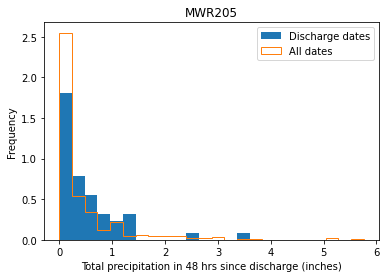

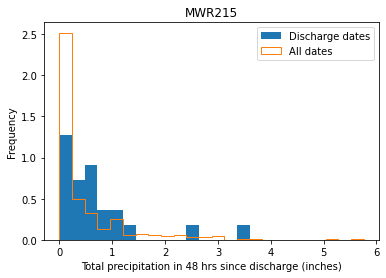

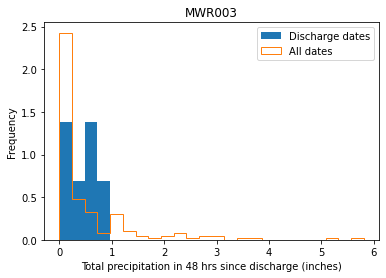

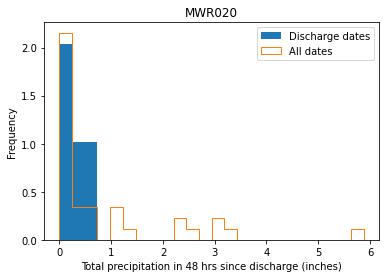

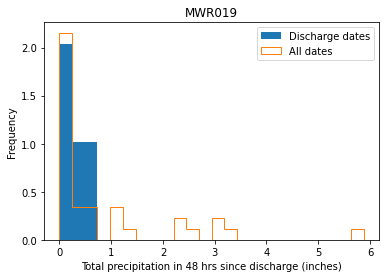

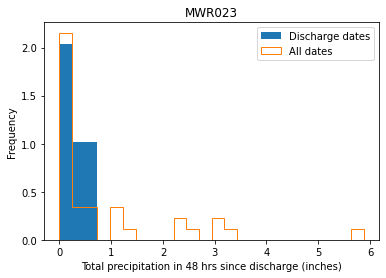

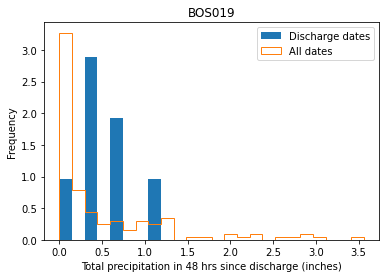

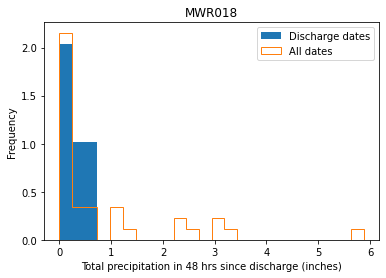

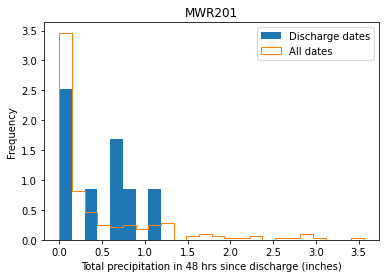

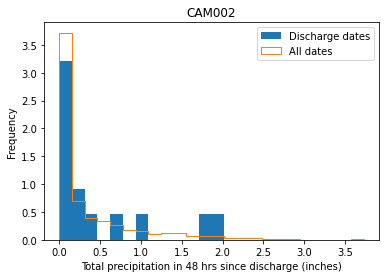

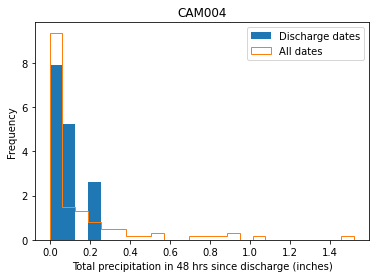

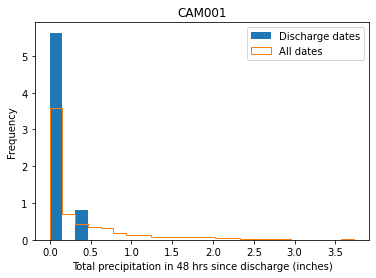

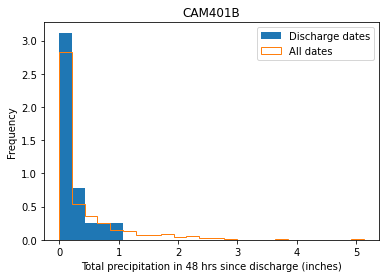

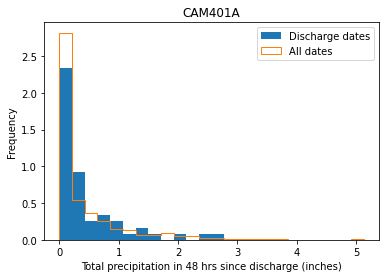

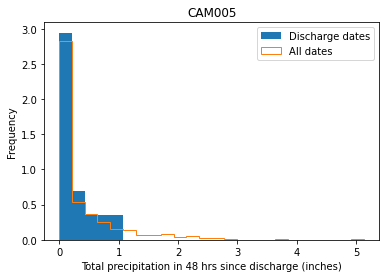

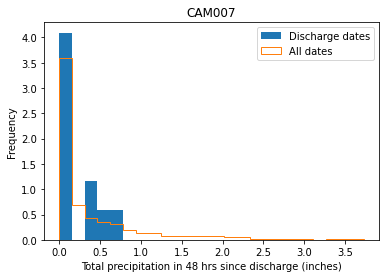

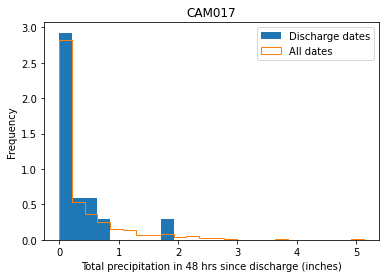

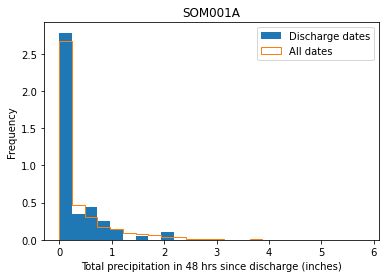

In [38]:
# 2 day period - per location
for location in cso_data_df['CSO Number'].unique():
    plot_evaluate_prev_precip(48, location=location)

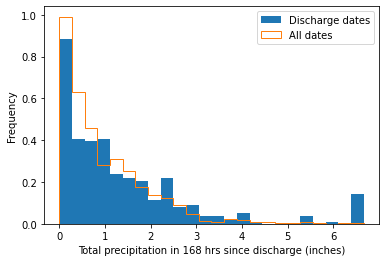

In [39]:
# 1 week period
plot_evaluate_prev_precip(24 * 7)

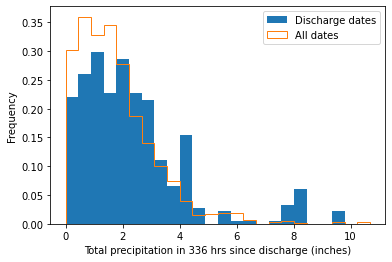

In [40]:
# 2 week period
plot_evaluate_prev_precip(24 * 14)

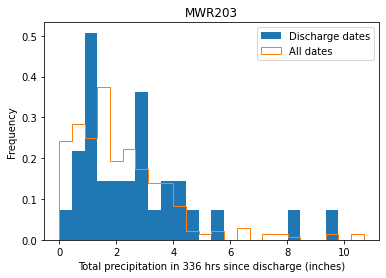

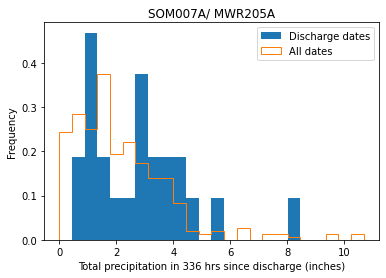

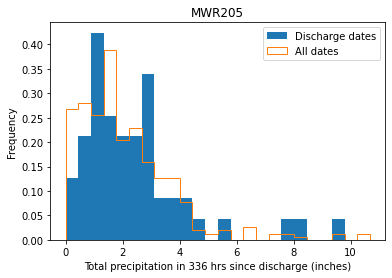

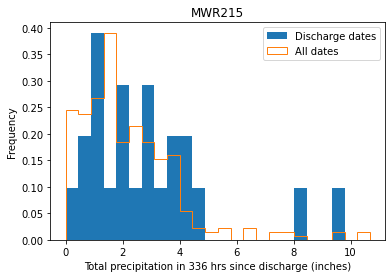

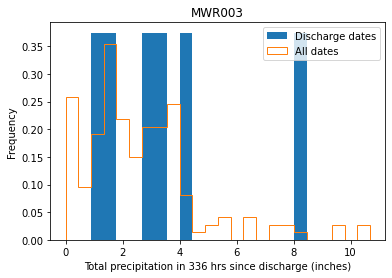

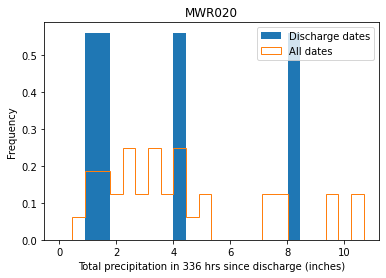

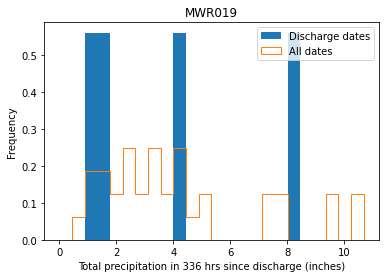

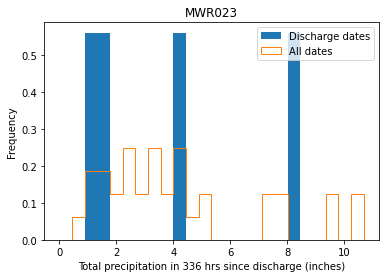

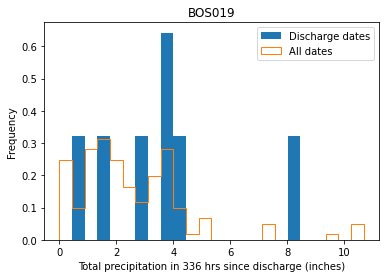

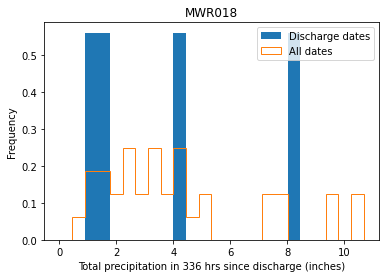

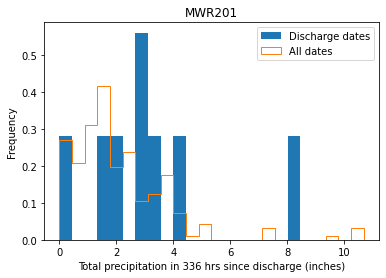

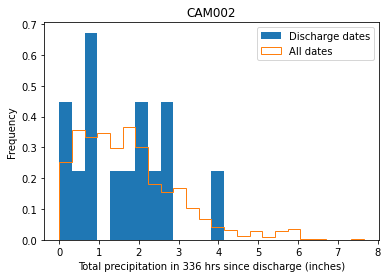

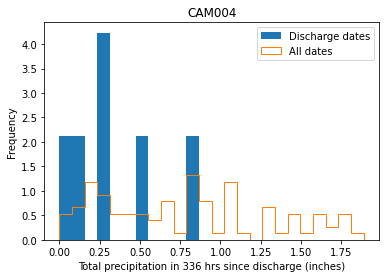

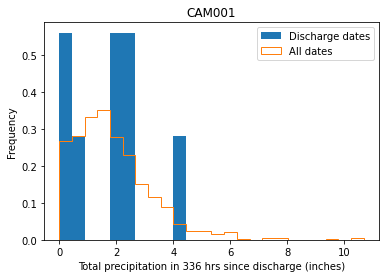

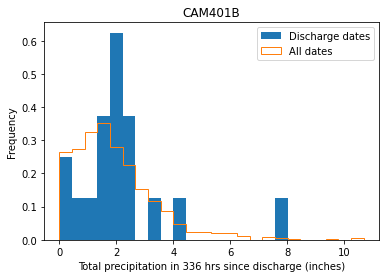

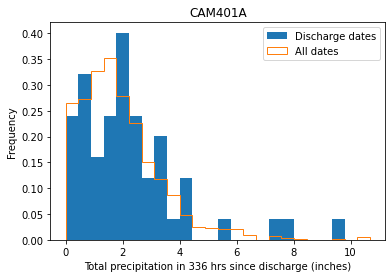

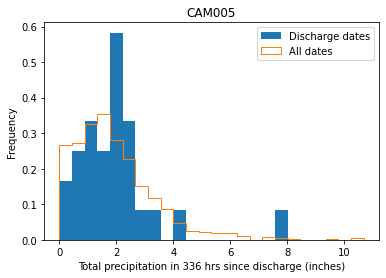

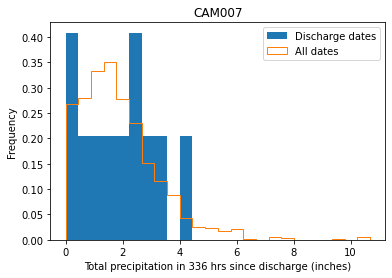

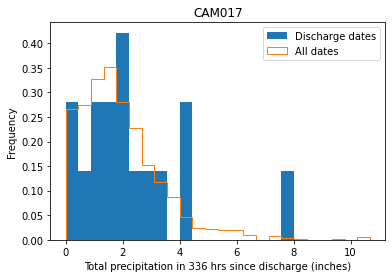

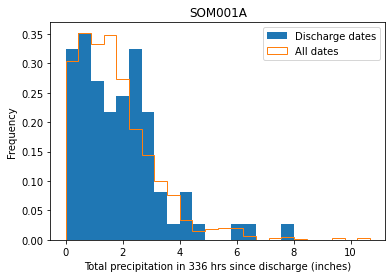

In [41]:
# 2 week period - per location
for location in cso_data_df['CSO Number'].unique():
    plot_evaluate_prev_precip(24 * 14, location=location)